# ClimateQ&A
---
Goal of the notebook: Recommended graphs functionality

Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:
- What do I put for query instruction ?
  - Default is "Represent this sentence for searching relevant passages:"
  - embedding_function = get_embeddings_function(query_instruction="")

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [1]:
import pandas as pd 
import numpy as np
import os
from IPython.display import display, Markdown

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

## 1. Import objects
### 1.1 LLM

In [17]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

### 1.2 Embedding

In [18]:
from climateqa.engine.embeddings import get_embeddings_function

embeddings_function = get_embeddings_function()

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 1.3 Reranker

In [16]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")
reranker

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


### 1.4 IPCC vectorstore

In [10]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore

vectorstore = get_pinecone_vectorstore(embeddings_function)

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


## 2 Vectorstore

### 2.1 IEA data

In [6]:
from langchain_community.document_loaders import DataFrameLoader
from langchain_chroma import Chroma

df_iea = pd.read_csv("/home/dora/climate-question-answering/data/charts_iea.csv")
df_iea = df_iea.rename(columns={'url': 'returned_content'})
df_iea["doc_id"] = "iea_" + df_iea.index.astype(str)
df_iea["source"] = "IEA"
df_iea.head()

,title,returned_content,sources,notes,appears_in,appears_in_url,doc_id,source
0,Capital requirements for mining to meet demand...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on data from S&P Global and...,Capital requirements are calculated based on c...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_0,IEA
1,"IEA energy transition mineral price index, Jan...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,IEA energy transition minerals price index is ...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_1,IEA
2,Price developments of minerals and metals by c...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,"Base metals include iron, aluminium, zinc and ...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_2,IEA
3,Capital expenditure on nonferrous metal produc...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on company annual reports a...,"For diversified majors, capex on the productio...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_3,IEA
4,"Selected environmental, social and governance ...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on the latest sustainabilit...,GHG= greenhouse gas. Aggregated data for 25 ma...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_4,IEA


In [7]:
# Load csv file of charts
loader_iea = DataFrameLoader(df_iea, page_content_column='title')
documents_iea = loader_iea.load()
len(documents_iea)

5355

### 2.2 OWID data

In [8]:
df_owid = pd.read_csv("/home/dora/climate-question-answering/data/charts_owid.csv")

# rename column 'embedding' to 'returned_content'
df_owid = df_owid.rename(columns={'embedding': 'returned_content'})
df_owid.head()

df_owid["doc_id"] = "owid_" + df_owid.index.astype(str)
df_owid["source"] = "OWID"
df_owid.head()

,category,title,url,returned_content,subtitle,doc_id,source
0,Access to Energy,Number of people with and without access to cl...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_0,OWID
1,Access to Energy,Number of people without access to clean fuels...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_1,OWID
2,Access to Energy,"People without clean fuels for cooking, by wor...",https://ourworldindata.org/grapher/people-with...,"<iframe src=""https://ourworldindata.org/graphe...",Data source: World Bank,owid_2,OWID
3,Access to Energy,Share of the population without access to clea...,https://ourworldindata.org/grapher/share-of-th...,"<iframe src=""https://ourworldindata.org/graphe...",Access to clean fuels or technologies such as ...,owid_3,OWID
4,Access to Energy,Share with access to electricity vs. per capit...,https://ourworldindata.org/grapher/share-with-...,"<iframe src=""https://ourworldindata.org/graphe...",Having access to electricity is defined in int...,owid_4,OWID


In [9]:
loader_owid = DataFrameLoader(df_owid, page_content_column='title')
documents_owid = loader_owid.load()
len(documents_owid)

2202

### 2.3 Merged Data Loader

In [10]:
from langchain_community.document_loaders.merge import MergedDataLoader

loader_all = MergedDataLoader(loaders=[loader_iea, loader_owid])
documents_all = loader_all.load()
len(documents_all)

7557

In [11]:
documents_all[-1]

Document(page_content='Wildfire area burned by land cover type', metadata={'category': 'Wildfires', 'url': 'https://ourworldindata.org/grapher/annual-burned-area-by-landcover', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/annual-burned-area-by-landcover?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'subtitle': 'Total area of forests, savannas, shrublands/grasslands, croplands, and other land that have been burned as a result of wildfires each year.', 'doc_id': 'owid_2201', 'source': 'OWID'})

### 2.4 Chroma vectorstore

In [12]:
# DO NOT RUN AGAIN (persisted)
# vectorstore_graphs = Chroma.from_documents(documents_all, embeddings_function, persist_directory="/home/dora/climate-question-answering/data/vectorstore")

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [9]:
from langchain_chroma import Chroma

vectorstore_graphs = Chroma(persist_directory="/home/dora/climate-question-answering/data/vectorstore", embedding_function=embeddings_function)

In [5]:
vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")

[(Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Water Pollution', 'doc_id': 'owid_2151', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Water quality is assessed by means of core physical and chemical parameters that reflect natural water quality. A water body is classified as "good" quality if at least 80% of monitoring values meet target quality levels.', 'url': 'https://ourworldindata.org/grapher/water-bodies-good-water-quality'}),
  0.46955348387336615),
 (Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Water Use & Stress', 'doc_id': 'owid_2184', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy

## 3. Retriever for recommended graphs

### 3.1 Custom retriever

In [18]:
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents.base import Document
from langchain_core.vectorstores import VectorStore
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

from typing import List

class GraphRetriever(BaseRetriever):
    vectorstore:VectorStore
    sources:list = ["IEA", "OWID"] # plus tard ajouter OurWorldInData # faudra integrate avec l'autre retriever
    threshold:float = 0.5
    k_total:int = 10

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        # Check if all elements in the list are IEA or OWID
        assert isinstance(self.sources,list)
        assert any([x in ["IEA", "OWID"] for x in self.sources])

        # Prepare base search kwargs
        filters = {}

        filters["source"] = {"$in": self.sources}

        docs = self.vectorstore.similarity_search_with_score(query=query, filter=filters, k=self.k_total)
        
        # Filter if scores are below threshold
        docs = [x for x in docs if x[1] > self.threshold]

        # Add score to metadata
        results = []
        for i,(doc,score) in enumerate(docs):
            doc.metadata["similarity_score"] = score
            doc.metadata["content"] = doc.page_content
            results.append(doc)

        return results

In [21]:
retriever = GraphRetriever(vectorstore=vectorstore_graphs, sources=["OWID"])

In [22]:
retriever.invoke("hydrogen import evolutions")

[Document(page_content='Energy imports and exports', metadata={'category': 'Energy', 'doc_id': 'owid_969', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Energy trade, measured as the percentage of energy use. Positive values indicate a country or region is a net importer of energy. Negative numbers indicate a country or region is a net exporter.', 'url': 'https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use', 'similarity_score': 0.7722017765045166, 'content': 'Energy imports and exports'}),
 Document(page_content='Import of environmentally sound technologies', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_400', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/import-of-environmentally-sound-technologies?tab=

### 3.2 Retriever node

In [86]:
import sys
import os
from contextlib import contextmanager

from climateqa.engine.reranker import rerank_docs



def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result


@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def make_graph_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

        def retrieve_graphs(state):
            print("---- Retrieving graphs ----")
            
            POSSIBLE_SOURCES = ["IEA", "OWID"]
            questions = state["questions"]
            sources_input = state["sources_input"]

            auto_mode = "auto" in sources_input

            # There are several options to get the final top k
            # Option 1 - Get 100 documents by question and rerank by question
            # Option 2 - Get 100/n documents by question and rerank the total
            if rerank_by_question:
                k_by_question = divide_into_parts(k_final,len(questions))
            
            docs = []
            
            for i,q in enumerate(questions):
                
                question = q["question"]
                
                print(f"Subquestion {i}: {question}")
                
                # If auto mode, we use all sources
                if auto_mode:
                    sources = POSSIBLE_SOURCES
                # Otherwise, we use the config
                else:
                    sources = sources_input

                if any([x in POSSIBLE_SOURCES for x in sources]):

                    sources = [x for x in sources if x in POSSIBLE_SOURCES]
                    
                    # Search the document store using the retriever
                    retriever = GraphRetriever(
                        vectorstore = vectorstore,
                        sources = sources,
                        k_total = k_before_reranking,
                        threshold = 0.5,
                        )
                    docs_question = retriever.get_relevant_documents(question)
                    
                    # Rerank
                    if reranker is not None:
                        with suppress_output():
                            docs_question = rerank_docs(reranker,docs_question,question)
                    else:
                        # Add a default reranking score
                        for doc in docs_question:
                            doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
                        
                    # If rerank by question we select the top documents for each question
                    if rerank_by_question:
                        docs_question = docs_question[:k_by_question[i]]
                        
                    # Add sources used in the metadata
                    for doc in docs_question:
                        doc.metadata["sources_used"] = sources
                    
                    print(f"{len(docs_question)} graphs retrieved for subquestion {i + 1}: {docs_question}")
                    
                    # Add to the list of docs
                    docs.extend(docs_question)

                else:
                    print(f"There are no graphs which match the sources filtered on. Sources filtered on: {sources}. Sources available: {POSSIBLE_SOURCES}.")
                    
                # Sorting the list in descending order by rerank_score
                # Then select the top k
                docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
                docs = docs[:k_final]

            return {"recommended_content": docs}
        
        return retrieve_graphs

In [87]:
# import sys
# import os
# from contextlib import contextmanager

# from climateqa.engine.reranker import rerank_docs


# def divide_into_parts(target, parts):
#     # Base value for each part
#     base = target // parts
#     # Remainder to distribute
#     remainder = target % parts
#     # List to hold the result
#     result = []
    
#     for i in range(parts):
#         if i < remainder:
#             # These parts get base value + 1
#             result.append(base + 1)
#         else:
#             # The rest get the base value
#             result.append(base)
    
#     return result


# @contextmanager
# def suppress_output():
#     # Open a null device
#     with open(os.devnull, 'w') as devnull:
#         # Store the original stdout and stderr
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         # Redirect stdout and stderr to the null device
#         sys.stdout = devnull
#         sys.stderr = devnull
#         try:
#             yield
#         finally:
#             # Restore stdout and stderr
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr



# def make_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

#     def retrieve_documents(state):
        
#         POSSIBLE_SOURCES = ["IEA","OWID"]
#         questions = state["questions"]
#         sources_input = state["sources_input"]
        
#         # Sert à rien pour l'instant puisqu'on a des valeurs par défaut et qu'on fait pas de query transformation sur les sources de graphs
#         # Use sources from the user input or from the LLM detection
#         if "sources_input" not in state or state["sources_input"] is None:
#             sources_input = ["auto"]
#         else:
#             sources_input = state["sources_input"]
#         auto_mode = "auto" in sources_input

#         # There are several options to get the final top k
#         # Option 1 - Get 100 documents by question and rerank by question
#         # Option 2 - Get 100/n documents by question and rerank the total
#         if rerank_by_question:
#             k_by_question = divide_into_parts(k_final,len(questions))
        
#         docs = []
        
#         for i,q in enumerate(questions):
            
#             sources = q["sources"]
#             question = q["question"]
            
#             # If auto mode, we use the sources detected by the LLM
#             if auto_mode:
#                 sources = [x for x in sources if x in POSSIBLE_SOURCES]
                
#             # Otherwise, we use the config
#             else:
#                 sources = sources_input
                
#             # Search the document store using the retriever
#             # Configure high top k for further reranking step
#             retriever = GraphRetriever(
#                 vectorstore=vectorstore,
#                 sources = sources,
#                 k_total = k_before_reranking,
#                 threshold = 0.5,
#                 )
#             docs_question = retriever.get_relevant_documents(question)
            
#             # Rerank
#             if reranker is not None:
#                 with suppress_output():
#                     docs_question = rerank_docs(reranker,docs_question,question)
#             else:
#                 # Add a default reranking score
#                 for doc in docs_question:
#                     # doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
#                     doc.metadata["reranking_score"] = "No reranking"
                
#             # If rerank by question we select the top documents for each question
#             if rerank_by_question:
#                 docs_question = docs_question[:k_by_question[i]]
                
#             # Add sources used in the metadata
#             for doc in docs_question:
#                 doc.metadata["sources_used"] = sources
            
#             # Add to the list of docs
#             docs.extend(docs_question)
            
#         # Sorting the list in descending order by rerank_score
#         # Then select the top k
#         docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
#         docs = docs[:k_final]
        
#         new_state = {"documents": docs}
#         return new_state
    
#     return retrieve_documents

## 4. Node functions

In [182]:
from operator import itemgetter

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts.base import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="""Title: {page_content}. \n\n Embedding link: {returned_content}""")

def _combine_recommended_content(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, sep="\n\n-----------------\n\n"
):

    doc_strings =  []

    for i,doc in enumerate(docs):
        # chunk_type = "Doc" if doc.metadata["chunk_type"] == "text" else "Image"
        chunk_type = "Graph"
        if isinstance(doc,str):
            doc_formatted = doc
        else:
            doc_formatted = format_document(doc, document_prompt)

        doc_string = f"{chunk_type} {i+1}: \n\n" + doc_formatted
        # doc_string = doc_string.replace("\n"," ") 
        doc_strings.append(doc_string)

    return sep.join(doc_strings)

In [183]:
display(Markdown(_combine_recommended_content(output["recommended_content"])))

Graph 1: 

Title: Hydrogen use in the Sustainable Development Scenario, 2019-2050. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/hydrogen-use-in-the-sustainable-development-scenario-2019-2050

-----------------

Graph 2: 

Title: Global hydrogen demand by sector in the Sustainable Development Scenario, 2019-2070. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-hydrogen-demand-by-sector-in-the-sustainable-development-scenario-2019-2070

-----------------

Graph 3: 

Title: Role of north-western Europe in the European hydrogen landscape, 2020. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/role-of-north-western-europe-in-the-european-hydrogen-landscape-2020

-----------------

Graph 4: 

Title: Reduction in global hydrogen demand by sector in the Reduced Innovation Case, relative to the Sustainable Development Scenario, 2030-2040. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/reduction-in-global-hydrogen-demand-by-sector-in-the-reduced-innovation-case-relative-to-the-sustainable-development-scenario-2030-2040

-----------------

Graph 5: 

Title: Global power sector demand for hydrogen and hydrogen-based fuels in the Net Zero Scenario. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-power-sector-demand-for-hydrogen-and-hydrogen-based-fuels-in-the-net-zero-scenario

-----------------

Graph 6: 

Title: Energy imports and exports. 

 Embedding link: <iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>

-----------------

Graph 7: 

Title: Hydrogen demand in industry, 2020. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/hydrogen-demand-in-industry-2020

-----------------

Graph 8: 

Title: Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/low-emissions-hydrogen-imports-into-northwest-europe-by-status-based-on-announced-projects-2030-2040

-----------------

Graph 9: 

Title: Top five countries by total energy supply by energy source, 2018. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/top-five-countries-by-total-energy-supply-by-energy-source-2018

-----------------

Graph 10: 

Title: Global demand for pure hydrogen, 1975-2018. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-demand-for-pure-hydrogen-1975-2018

-----------------

Graph 11: 

Title: Top five countries by total energy supply by energy source, 2019. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/top-five-countries-by-total-energy-supply-by-energy-source-2019

In [12]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from climateqa.engine.chains.prompts import answer_prompt_graph_template

class RecommendedGraph(BaseModel):
    title: str = Field(description="Title of the graph")
    embedding: str = Field(description="Embedding link of the graph")

# class RecommendedGraphs(BaseModel):
#     recommended_content: List[RecommendedGraph] = Field(description="List of recommended graphs")

def make_rag_graph_chain(llm):
    parser = JsonOutputParser(pydantic_object=RecommendedGraph)
    prompt = PromptTemplate(
        template=answer_prompt_graph_template,
        input_variables=["query", "recommended_content"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm | parser
    return chain

def make_rag_graph_node(llm):
    chain = make_rag_graph_chain(llm)

    def answer_rag_graph(state):
        output = chain.invoke(state)
        return {"graph_returned": output}

    return answer_rag_graph

## 5. Graph

### 5.1 Make graph agent

In [19]:
import sys
import os
from contextlib import contextmanager

from langchain.schema import Document
from langgraph.graph import END, StateGraph
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

from typing_extensions import TypedDict
from typing import List, Dict

from IPython.display import display, HTML, Image

from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.intent_categorization import make_intent_categorization_node
from climateqa.engine.chains.retriever import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.set_defaults import set_defaults
from climateqa.engine.chains.graph_retriever import make_graph_retriever_node


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    user_input : str
    language : str
    intent : str
    query: str
    questions : List[dict]
    answer: str
    audience: str
    sources_input: List[str]
    documents: List[Document]
    recommended_content : List[Document]
    graph_returned: Dict[str,str]

def search(state):
    return {}

def route_intent(state):
    intent = state["intent"]
    if intent in ["chitchat","esg"]:
        return "answer_chitchat"
    elif intent == "ai_impact":
        return "answer_ai_impact"
    else:
        # Search route
        return "search"
    
def route_translation(state):
    if state["language"].lower() == "english":
        return "transform_query"
    else:
        return "translate_query"
    
def route_based_on_relevant_docs(state,threshold_docs=0.2):
    docs = [x for x in state["documents"] if x.metadata["reranking_score"] > threshold_docs]
    if len(docs) > 0:
        return "answer_rag"
    else:
        return "answer_rag_no_docs"
    

def make_id_dict(values):
    return {k:k for k in values}

def make_graph_agent(llm, vectorstore_ipcc, vectorstore_graphs, reranker, threshold_docs=0.2):
    
    workflow = StateGraph(GraphState)

    # Define the node functions
    categorize_intent = make_intent_categorization_node(llm)
    transform_query = make_query_transform_node(llm)
    translate_query = make_translation_node(llm)
    answer_chitchat = make_chitchat_node(llm)
    answer_ai_impact = make_ai_impact_node(llm)
    retrieve_documents = make_retriever_node(vectorstore_ipcc, reranker)
    retrieve_graphs = make_graph_retriever_node(vectorstore_graphs, reranker)
    answer_rag_graph = make_rag_graph_node(llm)
    answer_rag = make_rag_node(llm, with_docs=True)
    answer_rag_no_docs = make_rag_node(llm, with_docs=False)

    # Define the nodes
    workflow.add_node("set_defaults", set_defaults)
    workflow.add_node("categorize_intent", categorize_intent)
    workflow.add_node("search", search)
    workflow.add_node("transform_query", transform_query)
    workflow.add_node("translate_query", translate_query)
    workflow.add_node("answer_chitchat", answer_chitchat)
    workflow.add_node("answer_ai_impact", answer_ai_impact)
    workflow.add_node("retrieve_graphs", retrieve_graphs)
    workflow.add_node("answer_rag_graph", answer_rag_graph)
    workflow.add_node("retrieve_documents", retrieve_documents)
    workflow.add_node("answer_rag", answer_rag)
    workflow.add_node("answer_rag_no_docs", answer_rag_no_docs)

    # Entry point
    workflow.set_entry_point("set_defaults")

    # CONDITIONAL EDGES
    workflow.add_conditional_edges(
        "categorize_intent",
        route_intent,
        make_id_dict(["answer_chitchat","answer_ai_impact","search"])
    )

    workflow.add_conditional_edges(
        "search",
        route_translation,
        make_id_dict(["translate_query","transform_query"])
    )

    workflow.add_conditional_edges(
        "retrieve_documents",
        lambda x : route_based_on_relevant_docs(x,threshold_docs=threshold_docs),
        make_id_dict(["answer_rag","answer_rag_no_docs"])
    )

    # Define the edges
    workflow.add_edge("set_defaults", "categorize_intent")
    workflow.add_edge("translate_query", "transform_query")
    workflow.add_edge("transform_query", "retrieve_graphs")
    workflow.add_edge("retrieve_graphs", "answer_rag_graph")
    workflow.add_edge("answer_rag_graph", "retrieve_documents")
    workflow.add_edge("answer_rag", END)
    workflow.add_edge("answer_rag_no_docs", END)
    workflow.add_edge("answer_chitchat", END)
    workflow.add_edge("answer_ai_impact", END)

    # Compile
    app = workflow.compile()
    return app




def display_graph(app):

    display(
        Image(
            app.get_graph(xray = True).draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

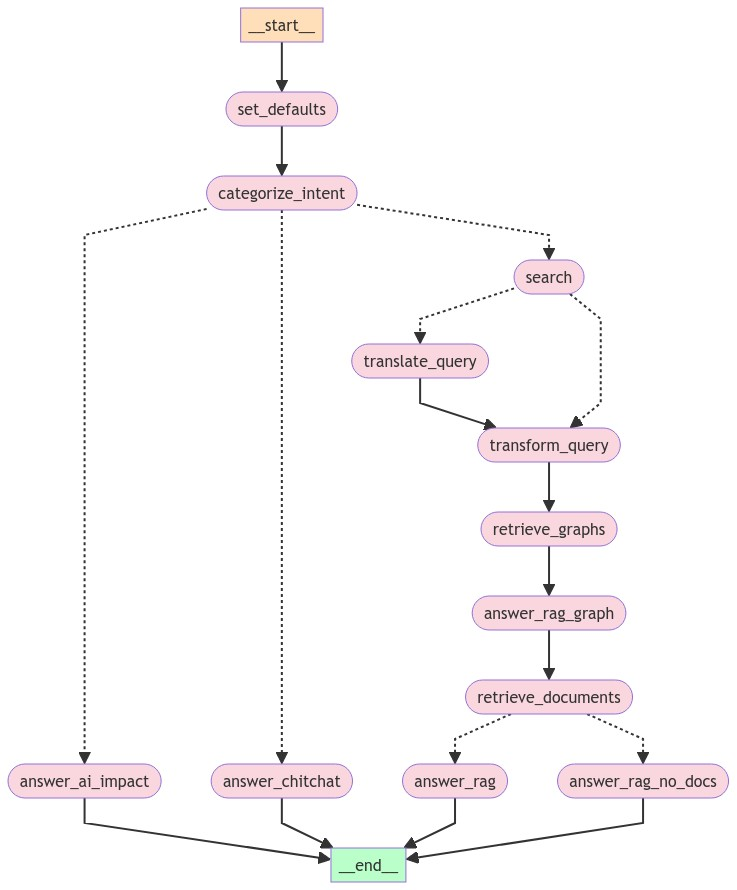

In [20]:
app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

### 5.2 Testing graph agent

In [210]:
output = await app.ainvoke({"user_input": "What are hydrogen imports?"})
output

---- Setting defaults ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What is the role of hydrogen in the energy sector?
5 graphs retrieved for subquestion 1: [Document(page_content='Hydrogen use in the Sustainable Development Scenario, 2019-2050', metadata={'appears_in': 'Iron and Steel Technology Roadmap', 'appears_in_url': 'https://www.iea.org/reports/iron-and-steel-technology-roadmap', 'doc_id': 'iea_3435', 'notes': '“Electrolytic H2 injected” corresponds to hydrogen blended into commercial blast furnaces and DRI furnaces. “Electrolytic H2 primary reducing agent” refers to hydrogen use in the hydrogen-based DRI route.', 'returned_content': 'https://www.iea.org/data-and-statistics/charts/hydrogen-use-in-the-sustainable-development-scenario-2019-2050', 'source': 'IEA', 'similarity_score': 0.695563554763794, 'content': 'Hydrogen use in the Sustainable Development Scenario, 2019-2050', 'reranking_score': 0.9951463341712952, 'query_used_for_retrieval': 'What is the role of hydrogen in the energy sector?', 'source

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'user_input': 'What are hydrogen imports?',
 'language': 'English',
 'intent': 'search',
 'query': 'What are hydrogen imports?',
 'questions': [{'question': 'What is the role of hydrogen in the energy sector?',
   'sources': ['IPCC']},
  {'question': 'How are hydrogen imports used in different industries?',
   'sources': ['IPCC', 'IPBES', 'IPOS']},
  {'question': "What are the benefits of hydrogen imports for a country's energy supply?",
   'sources': ['IPCC']}],
 'answer': 'Hydrogen imports refer to the process of importing hydrogen-based chemicals and materials that are processed using low-carbon electricity and hydrogen from regions with abundant low-GHG energy and feedstocks. This reallocation of industries to regions with such resources can have global distributional effects on employment and economic structure [Doc 1, Doc 6, Doc 9].\n\nIn the context of reducing industry GHG emissions, hydrogen imports play a crucial role in promoting mitigation options, including demand managem

In [211]:
output["graph_returned"]

{'title': 'Energy imports and exports',
 'embedding': '<iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>'}

In [78]:
async for event in app.astream_events({"user_input": "What are hydrogen imports?"}, version = "v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'user_input': 'What are hydrogen imports?'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4e6f802f-dc8d-490a-80b7-46734f83b287', 'metadata': {}}
{'event': 'on_chain_start', 'data': {'input': {'user_input': 'What are hydrogen imports?'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '301b84ea-e0aa-43b8-af35-a0d142be50ac', 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}}
{'event': 'on_chain_end', 'data': {'output': {'user_input': 'What are hydrogen imports?'}, 'input': {'user_input': 'What are hydrogen imports?'}}, 'run_id': '301b84ea-e0aa-43b8-af35-a0d142be50ac', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}}
{'event': 'on_chain_start', 'data': {}, 'name': 'set_defaults', 'tags': ['graph:step:1'], 'run_id': '1c2cd77b-024b-46ea-bdb0-c3d64f77e367', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'set_defau

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-d63968f6-4cb1-41f5-a21a-8c0b9608beb4')}, 'run_id': 'd63968f6-4cb1-41f5-a21a-8c0b9608beb4', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-d63968f6-4cb1-41f5-a21a-8c0b9608beb4')}, 'run_id': 'd63968f6-4cb1-41f5-a21a-8c0b9608beb4', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'intent', 'name': ''}}, id='run-d63968f6-4cb1-41f5-a21a-8c0b9608beb4')

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryDecomposition'}}, id='run-fd37c3c4-8c4d-47a4-be06-1abc836d7d83')}, 'run_id': 'fd37c3c4-8c4d-47a4-be06-1abc836d7d83', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-fd37c3c4-8c4d-47a4-be06-1abc836d7d83')}, 'run_id': 'fd37c3c4-8c4d-47a4-be06-1abc836d7d83', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'questions', 'name': ''}}, id='run-fd37c3c4-8c4d-47a4-be06-1abc836d7d83')

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-dd6e6cbc-1172-42b3-bdb3-7c80a42e6025')}, 'run_id': 'dd6e6cbc-1172-42b3-bdb3-7c80a42e6025', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-dd6e6cbc-1172-42b3-bdb3-7c80a42e6025')}, 'run_id': 'dd6e6cbc-1172-42b3-bdb3-7c80a42e6025', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-dd6e6cbc-1172-42b3-bdb3-7c80a42e6025')}, 'run

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-b19dcc39-2e24-4afd-8d65-063d016e4423')}, 'run_id': 'b19dcc39-2e24-4afd-8d65-063d016e4423', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-b19dcc39-2e24-4afd-8d65-063d016e4423')}, 'run_id': 'b19dcc39-2e24-4afd-8d65-063d016e4423', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-b19dcc39-2e24-4afd-8d65-063d016e4423')}, 'run

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-46524973-94d6-4db8-bba9-5e40dccb3785')}, 'run_id': '46524973-94d6-4db8-bba9-5e40dccb3785', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-46524973-94d6-4db8-bba9-5e40dccb3785')}, 'run_id': '46524973-94d6-4db8-bba9-5e40dccb3785', 'name': 'ChatOpenAI', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': 'sources', 'name': ''}}, id='run-46524973-94d6-4db8-bba9-5e40dccb3785')}, 'run

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='', id='run-13fec420-07d2-4257-bfa3-a3a2df8a57a3')}, 'run_id': '13fec420-07d2-4257-bfa3-a3a2df8a57a3', 'name': 'ChatOpenAI', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='Hy', id='run-13fec420-07d2-4257-bfa3-a3a2df8a57a3')}, 'run_id': '13fec420-07d2-4257-bfa3-a3a2df8a57a3', 'name': 'ChatOpenAI', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chunk': AIMessageChunk(content='dro', id='run-13fec420-07d2-4257-bfa3-a3a2df8a57a3')}, 'run_id': '13fec420-07d2-4257-bfa3-a3a2df8a57a3', 'name': 'ChatOpenAI', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}}
{'event': 'on_chat_model_stream', 'data': {'chu

In [21]:
inputs = {'user_input': 'What evidence do we have of climate change?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}
result = app.astream_events(inputs,version = "v1")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


In [22]:
async for event in result:
    print(event)

{'event': 'on_chain_start', 'run_id': 'e8d0a46f-8dd5-459e-b665-bb29877a555a', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': 'What evidence do we have of climate change?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_start', 'name': '__start__', 'run_id': '3b92d4d8-7c5d-4368-a116-15d26f9fe9cb', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'What evidence do we have of climate change?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_end', 'name': '__start__', 'run_id': '3b92d4d8-7c5d-4368-a116-15d26f9fe9cb', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'What evidence do we have of climate change?',

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'a2b1657e-045c-4c0b-9b45-b6bed746a901', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-a2b1657e-045c-4c0b-9b45-b6bed746a901')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'a2b1657e-045c-4c0b-9b45-b6bed746a901', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-a2b1657e-045c-4c0b-9b45-b6bed746a901')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'a2b1657e-045c-4c0b-9b45-b6bed746a901', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_inten

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '0b74a01b-90a6-4455-9002-72f2db3d4eee', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryDecomposition'}}, id='run-0b74a01b-90a6-4455-9002-72f2db3d4eee')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '0b74a01b-90a6-4455-9002-72f2db3d4eee', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-0b74a01b-90a6-4455-9002-72f2db3d4eee')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '0b74a01b-90a6-4455-9002-72f2db3d4eee', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', '

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3f01d343-1b7c-4e6f-8559-dd1cd2c6ced1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-3f01d343-1b7c-4e6f-8559-dd1cd2c6ced1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3f01d343-1b7c-4e6f-8559-dd1cd2c6ced1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-3f01d343-1b7c-4e6f-8559-dd1cd2c6ced1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3f01d343-1b7c-4e6f-8559-dd1cd2c6ced1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '7669613d-e1b6-4fcd-b908-c140d930ad3f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-7669613d-e1b6-4fcd-b908-c140d930ad3f')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '7669613d-e1b6-4fcd-b908-c140d930ad3f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-7669613d-e1b6-4fcd-b908-c140d930ad3f')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '7669613d-e1b6-4fcd-b908-c140d930ad3f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3d1decf7-62da-4977-9ede-4744b6876261', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-3d1decf7-62da-4977-9ede-4744b6876261')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3d1decf7-62da-4977-9ede-4744b6876261', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-3d1decf7-62da-4977-9ede-4744b6876261')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '3d1decf7-62da-4977-9ede-4744b6876261', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4b48aff8-f300-4995-818f-9ec20ba20964', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 6, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-4b48aff8-f300-4995-818f-9ec20ba20964')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4b48aff8-f300-4995-818f-9ec20ba20964', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 6, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='{\n', id='run-4b48aff8-f300-4995-818f-9ec20ba20964')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4b48aff8-f300-4995-818f-9ec20ba20964', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 6, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' ', id='run-4b48aff8-f300-4995-818f-9ec20ba20964')}}
{'event': 'on_chat_model_strea

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '80e47c59-d809-4daa-9f98-d57b732207e3', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 8, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-80e47c59-d809-4daa-9f98-d57b732207e3')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '80e47c59-d809-4daa-9f98-d57b732207e3', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 8, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='The', id='run-80e47c59-d809-4daa-9f98-d57b732207e3')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '80e47c59-d809-4daa-9f98-d57b732207e3', 'tags': ['seq:step:3'], 'metadata': {'langgraph_step': 8, 'langgraph_node': 'answer_rag', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' evidence', id='run-80e47c59-d809-4daa-9f98-d57b732207e3')}}
{'event': 'on_chat_model_stream', 'name'

In [22]:
from front.utils import make_html_source,parse_output_llm_with_sources,serialize_docs,make_toolbox
query = inputs["user_input"]
steps_display = {
"categorize_intent":("🔄️ Analyzing user message",True),
"transform_query":("🔄️ Thinking step by step to answer the question",True),
"retrieve_documents":("🔄️ Searching in the knowledge base",False),
}
history = [(query,None)]
start_streaming = False
intent = {}


async for event in result:

    if intent == {}:
        intent = event.get("data", {}).get("output", {}).get("intent", {})

    if (intent != "search" and event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] == "answer_rag") or (intent == "search" and event["event"] == "on_chat_model_stream"):
        if start_streaming == False:
            start_streaming = True
            history[-1] = (query,"")

        new_token = event["data"]["chunk"].content
        # time.sleep(0.01)
        previous_answer = history[-1][1]
        previous_answer = previous_answer if previous_answer is not None else ""
        answer_yet = previous_answer + new_token
        answer_yet = parse_output_llm_with_sources(answer_yet)
        history[-1] = (query,answer_yet)

    
    elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
        try:
            docs = event["data"]["output"]["documents"]
            docs_html = []
            for i, d in enumerate(docs, 1):
                docs_html.append(make_html_source(d, i))
            docs_html = "".join(docs_html)
        except Exception as e:
            print(f"Error getting documents: {e}")
            print(event)

    # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
    #     print(event)
    #     questions = event["data"]["input"]["questions"]
    #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
    #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
    #     history[-1] = (query,answer_yet)

    elif event["name"] == "retrieve_graphs" and event["event"] == "on_chain_end":
        try:
            graphs = event["data"]["output"]["recommended_content"]
        except Exception as e:
            print(f"Error getting graphs: {e}")
            print(event)


    for event_name,(event_description,display_output) in steps_display.items():
        if event["name"] == event_name:
            if event["event"] == "on_chain_start":
                # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
                # answer_yet = make_toolbox(event_description, "", checked = False)
                answer_yet = event_description
                history[-1] = (query,answer_yet)
            # elif event["event"] == "on_chain_end":
            #     answer_yet = ""
            #     history[-1] = (query,answer_yet)
                # if display_output:
                #     print(event["data"]["output"])

    # if op['path'] == path_reformulation: # reforulated question
    #     try:
    #         output_language = op['value']["language"] # str
    #         output_query = op["value"]["question"]
    #     except Exception as e:
    #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
    
    # if op["path"] == path_keywords:
    #     try:
    #         output_keywords = op['value']["keywords"] # str
    #         output_keywords = " AND ".join(output_keywords)
    #     except Exception as e:
    #         pass



    history = [tuple(x) for x in history]
    # yield history,docs_html,output_query,output_language,gallery,output_query,output_keywords

---- Setting defaults ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What are the key indicators of climate change?


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


5 graphs retrieved for subquestion 1: [Document(page_content='Key indicators of energy system change by scenario, 2020-2050', metadata={'appears_in': 'World Energy Outlook 2021', 'appears_in_url': 'https://www.iea.org/reports/world-energy-outlook-2021', 'doc_id': 'iea_2067', 'notes': 'Complex conversions are a primary energy source that has undergone two or more conversions before being delivered to end-users. It includes roundtrip battery storage.', 'returned_content': 'https://www.iea.org/data-and-statistics/charts/key-indicators-of-energy-system-change-by-scenario-2020-2050', 'source': 'IEA', 'similarity_score': 0.5951785445213318, 'content': 'Key indicators of energy system change by scenario, 2020-2050', 'reranking_score': 0.991706132888794, 'query_used_for_retrieval': 'What are the key indicators of climate change?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Change in CO2 emissions by sector and scenario, 2020-2050', metadata={'appears_in': 'World Energy Outlook 2

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
